# This notebook has been productionized in .\tensor-hero\Preprocessing\audio_functions.py

see function music2tensor()

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
# Define path to chart_functions and add to system path for import
d = str(Path().resolve().parent)
songpath = d + r'\Prototypes\Toy Training Data\Brand New - Degausser (Chezy)\song.ogg'

In [8]:
# Load the song and get the sample rate, sr

data, sr = librosa.load(songpath)
print(sr)

22050


In [9]:
# Upsample to 44100, mp3 files have this sample rate. It will be easiest to convert all the audio files to 44100 before processing
data = librosa.resample(data, sr, 44100)

In [10]:
# Get the STFT for three separate window lengths - 93ms, 46ms, 23ms
# Absolute value is necessary because STFT returns complex numbers
S_93 = np.abs(librosa.stft(data, n_fft = 2048, hop_length = 441))  # Hop length = stride
S_46 = np.abs(librosa.stft(data, n_fft = 1024, hop_length = 441))
S_23 = np.abs(librosa.stft(data, n_fft = 512, hop_length = 441))


In [11]:
# Create mel filters
mel93 = librosa.filters.mel(44100, n_fft = 2048, n_mels = 80)
mel46 = librosa.filters.mel(44100, n_fft = 1024, n_mels = 80)
mel23 = librosa.filters.mel(44100, n_fft = 512, n_mels = 80)

In [12]:
# Transform the STFT matrix to the mel filterbank, reducing dimensionality of columns to 80
S_93 = np.matmul(mel93,S_93)
S_46 = np.matmul(mel46,S_46)
S_23 = np.matmul(mel23,S_23)
print('The shape of the new filtered data is', S_93.shape)

The shape of the new filtered data is (80, 33426)


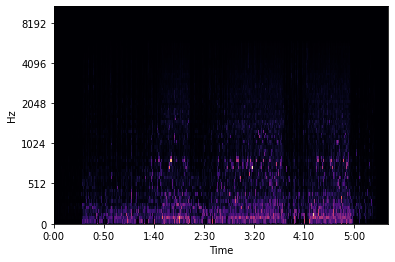

In [23]:
librosa.display.specshow(S_93, sr = 44100, hop_length=441, x_axis='time', y_axis='mel')

In [13]:
# Convert to dB for clearer spectrogram and to better represent human perception
S93db = librosa.amplitude_to_db(S_93, ref=np.max)
S46db = librosa.amplitude_to_db(S_46, ref=np.max)
S23db = librosa.amplitude_to_db(S_23, ref=np.max)

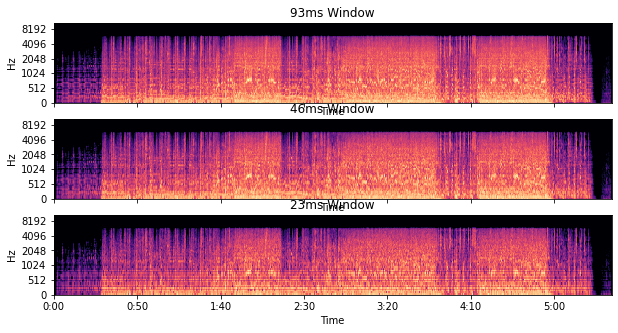

In [25]:
# Plot
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,5))
img1 = librosa.display.specshow(S93db, sr = 44100, hop_length=441, x_axis='time', y_axis='mel', ax=ax[0])
ax[0].set(title='93ms Window')
img2 = librosa.display.specshow(S46db, sr = 44100, hop_length=441, x_axis='time', y_axis='mel', ax=ax[1])
ax[1].set(title='46ms Window')
img3 = librosa.display.specshow(S23db, sr = 44100, hop_length=441, x_axis='time', y_axis='mel', ax=ax[2])
ax[2].set(title='23ms Window');

In [20]:
print(np.min(S93db))
sx = np.ones((80,7)) * np.min(S93db)
print(sx)

-80.0
[[-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80. -80. -80.]
 [-80.

In [21]:
# Prepend and append seven columns of zeros (even the first and last 10ms windows should have 70ms of prior context and posterior context)
append_arr = np.ones((80,7)) * np.min(S93db)
S93arr = np.c_[append_arr, S93db, append_arr]
S46arr = np.c_[append_arr, S46db, append_arr]
S23arr = np.c_[append_arr, S23db, append_arr]

In [22]:
# Sanity check - shapes of the arrays
print('S93arr shape =', S93arr.shape)
print('S46arr shape =', S46arr.shape)
print('S23arr shape =', S23arr.shape)
print(S23arr.shape[1], 'bins of 10ms windows =', S23arr.shape[1]/100, 'seconds')

S93arr shape = (80, 33440)
S46arr shape = (80, 33440)
S23arr shape = (80, 33440)
33440 bins of 10ms windows = 334.4 seconds


In [23]:
# Split up the arrays into 80 x 15 tensors representing 150ms of audio context
S93_split = np.array([S93arr[:, i-7 : i+8] for i in range(7, S93arr.shape[1] - 7)])
S46_split = np.array([S46arr[:, i-7 : i+8] for i in range(7, S46arr.shape[1] - 7)])
S23_split = np.array([S23arr[:, i-7 : i+8] for i in range(7, S23arr.shape[1] - 7)])


In [24]:
# Stack matrices along second dimenstion to create full tensor
S_tensor = np.stack((S93_split, S46_split, S23_split), axis=1)
print(S_tensor.shape)

(33426, 3, 80, 15)



## Tensor Axes

|Axis| Significance|
|--|--|
|0|10ms window (0 corresponds to first 10ms window)|
|1|window size \[ms\] (96 index 0, 46 index 1, or 23 index 2)|
|2| mel filter bin (80 total)
|3| Time bin (15 x 10ms bins)